# Train CTR Prediction Model

In [28]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split


In [2]:
raw_df = pd.read_parquet('./dataset_prep/downsampled.parquet')

In [8]:
y = raw_df['click']
X = raw_df.drop(columns=['click', 'market_price'])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [11]:
categorical_features = X_train.columns.values.tolist()
predictors = categorical_features

In [10]:
def fit(X_train, y_train, X_test, y_test, categorical_features, predictors, verbose=True):
    params = {
        'boosting_type': 'gbdt',
        'class_weight': None,
        'objective': 'binary',
        'learning_rate': 0.1,
        'n_estimators': 400,
        'max_leaves': 255,
        'max_depth': 8,
        'min_data_in_leaf': 100,
        'max_bin': 250, # max number of bins that feature values will be bucketed in
        'subsample_freq': 1, # frequency for bagging
        'bagging_fraction': 0.75,
        'colsample_bytree': 0.75,
        'cat_smooth': 20,
        'min_child_weight': 0,
        'min_split_gain': 0,
        'reg_alpha': 0.02,
        'reg_lambda': 0.02,
        'n_jobs': -1
    }

    clf = lgb.LGBMClassifier(**params)    
    clf.fit(
        X_train,
        y_train,
        categorical_feature=categorical_features,
        feature_name=predictors,
        #sample_weight=calc_weight(X_train.index),
        eval_set=[(X_test, y_test)],
        eval_metric='auc',
        early_stopping_rounds=100,
        verbose=verbose
    )
    return clf

In [12]:
clf = fit(X_train, y_train, X_test, y_test, categorical_features, predictors)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['feature_0', 'feature_1', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_2', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] num_leaves is set=31, max_leaves=255 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's auc: 0.818475	valid_0's binary_logloss: 0.348286
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.845931	valid_0's binary_logloss: 0.332859
[3]	valid_0's auc: 0.858887	valid_0's binary_logloss: 0.321537
[4]	valid_0's auc: 0.871004	valid_0's binary_logloss: 0.31041
[5]	valid_0's auc: 0.87382	valid_0's binary_logloss: 0.302734
[6]	valid_0's auc: 0.877157	valid_0's binary_logloss: 0.295372
[7]	valid_0's auc: 0.878601	valid_0's binary_logloss: 0.289645
[8]	valid_0's auc: 0.880188	valid_0's binary_logloss: 0.284812
[9]	valid_0's auc: 0.88089	valid_0's binary_logloss: 0.28045
[10]	valid_0's auc: 0.882326	valid_0's binary_logloss: 0.276238
[11]	valid_0's auc: 0.883871	valid_0's binary_logloss: 0.272419
[12]	valid_0's auc: 0.884813	valid_0's binary_logloss: 0.26924
[13]	valid_0's auc: 0.885528	valid_0's binary_logloss: 0.266152
[14]	valid_0's auc: 0.886742	valid_0's binary_logloss: 0.263654
[15]	valid_0's auc: 0.887764	valid_0's binary_logloss: 0

In [24]:
y_predicted = clf.predict_proba(X_test)[:,1]

In [40]:
from sklearn.metrics import log_loss, roc_auc_score

def print_score(y, y_predicted, desc):
    print(desc)
    print('LogLoss:', log_loss(y, y_predicted))
    print('AUC:', roc_auc_score(y, y_predicted))
    
    y_mean = np.mean(y)
    entropy = -1*(y_mean*np.log2(y_mean) + (1-y_mean)*np.log2(1-y_mean))
    print('RIG:', (entropy - log_loss(y, y_predicted))/entropy)

In [38]:
print_score(y_test, y_predicted, '')


LogLoss: 0.20961172115739563
AUC: 0.9197564239403136
RIG: 0.608242031635614


<AxesSubplot:title={'center':'Feature importance gain'}, xlabel='Feature importance', ylabel='Features'>

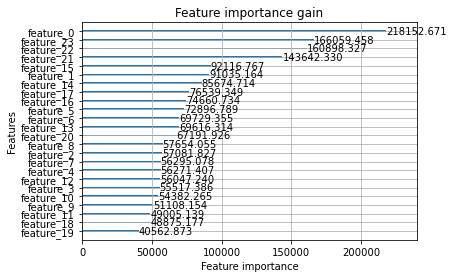

In [42]:
lgb.plot_importance(clf, importance_type='gain', title='Feature importance gain')